### Demonstration of how to get PSURGE Grib2 data into subsetted netCDF and make plots 

# First, get a grib2 file from: http://www.nws.noaa.gov/mdl/psurge2.0/

### Then, use wgrib2 to convert from GRIB2 to netCDF
#### prompt> wgrib2 Arthur_Adv14_2014070406_e10_cum_agl.grb  -netcdf Arthur_Adv14_2014070406_e10_cum_agl.nc

### Then, subset using NCO's ncea.  Subsetting is done along the x,y coordinate dimensions. 
#### prompt> ncea -d y,2500,3500 -d x,6700,7500 Arthur_Adv14_2014070406_e10_cum_agl.nc Arthur_Adv14_2014070406_e10_cum_agl_reduced.nc
#### prompt> ncea -d y,2500,3500 -d x,6700,7500 Arthur_Adv14_2014070406_e10_cum_agl.nc Arthur_Adv14_2014070406_e10_cum_agl_reduced.nc

In [2]:
import netCDF4
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
import os.path
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [16]:
url='http://opendap.renci.org:1935/thredds/dodsC/Test/Matthew_Adv37_2016100706_e10_cum_agl_reduced.nc'
#url='http://mrtee.europa.renci.org:8080/thredds/dodsC/testAll/Arthur_Adv14_2014070406_e10_cum_agl_reduced.ncml'
nc=netCDF4.Dataset(url)
print nc

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: CF-1.0
    History: Fri Oct  7 11:08:02 2016: ncea -d y,500,2500 -d x,5700,7500 Matthew_Adv37_2016100706_e10_cum_agl.nc Matthew_Adv37_2016100706_e10_cum_agl_reduced.nc
created by wgrib2
    GRIB2_grid_template: 30
    NCO: "4.5.3-alpha03"
    nco_openmp_thread_number: 1
    DODS_EXTRA.Unlimited_Dimension: time
    dimensions(sizes): time(13), x(1801), y(2001)
    variables(dimensions): float64 y(y), float64 x(x), float64 time(time), float64 latitude(y,x), float64 longitude(y,x), float32 SURGE_0maboveground(time,y,x)
    groups: 



In [17]:
lon=nc.variables['longitude']
#lond=lon[idy1:idy2,idx1:idx2]
lond=lon[:]
lond=lond-360
print np.min(lond), np.max(lond)

-86.4852239236 -73.2291427952


In [18]:
lat=nc.variables['latitude']
#latd=lat[idy1:idy2,idx1:idx2]
latd=lat[:]
print np.min(latd), np.max(latd)
latmn = np.mean(latd)
print latmn

24.1698411918 36.5546351345
30.4335275781


In [19]:
tidx=10
time=nc.variables['time']
print time.reference_date 
dtime = netCDF4.num2date(time[tidx],time.units)
datestr = dtime.strftime('%Y-%b-%d %H:%M')
print datestr
tstr= "PSURGE Grib2->netCDF test\nRef Date = %s\n%s\n" % ( time.reference_date,  os.path.basename(url))
print tstr

2016.10.07 06:00:00 UTC
2016-Oct-10 00:00
PSURGE Grib2->netCDF test
Ref Date = 2016.10.07 06:00:00 UTC
Matthew_Adv37_2016100706_e10_cum_agl_reduced.nc



In [20]:
var_name='SURGE_0maboveground'
var=nc.variables[var_name]
#zeta=var[tidx,idy1:idy2,idx1:idx2]
var_d=var[tidx,:,:]
vmin=np.nanmin(var_d)
vmax=np.nanmax(var_d)
print vmin, vmax

-1.92 4.145


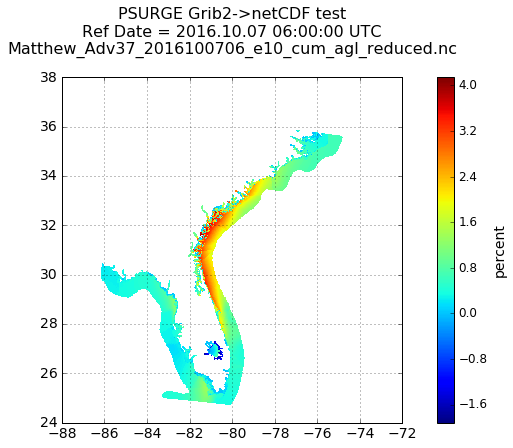

In [21]:
fig = plt.figure(figsize=(12,6), dpi=144)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_aspect(1.0/np.cos(latmn * np.pi / 180.0))

pc=pcolor(lond, latd, var_d, cmap=plt.cm.jet, vmin=vmin, vmax=vmax)
plt.title(tstr, fontsize=16)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.xlim((-80,-68))
#plt.ylim(( 32, 45))

cbax = fig.add_axes()  #([0.95, 0.1, 0.05, 0.8])
cb = plt.colorbar(pc, cax=cbax,  orientation='vertical')
cb.set_label(var.units, fontsize=14)
cb.ax.tick_params(axis='both', which='major', labelsize=12)

In [19]:
llcrnrlon=floor(np.min(lond))  # lower-left corner, lon
llcrnrlat=floor(np.min(latd))  # lower-left corner, lat
urcrnrlon=ceil(np.max(lond))   # upper-right corner, lon
urcrnrlat=ceil(np.max(latd))   # upper-right corner, lat
lon_0    =np.mean(lond)        # center of map domain (in degrees).
lat_1    =np.mean(latd)        # first standard parallel for lambert conformal
dl=10
dlon=urcrnrlon-llcrnrlon
dlat=urcrnrlat-llcrnrlat

print np.floor(llcrnrlon), dlon,dlat


-79.0 7.0 7.0


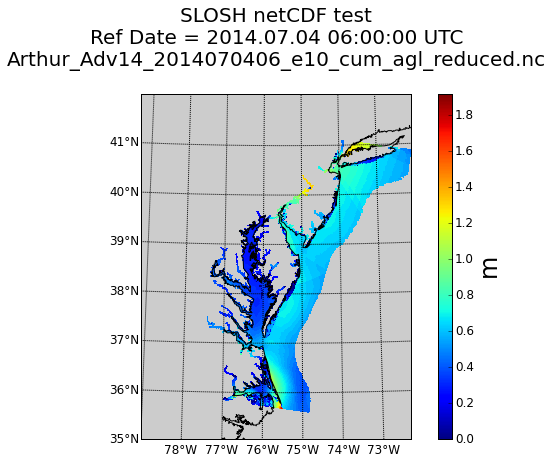

In [21]:
fig = plt.figure(figsize=(12,6), dpi=144)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

#m = Basemap(projection='kav7',lon_0=-80,resolution='l')

m = Basemap(llcrnrlon=llcrnrlon,
            llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon,
            urcrnrlat=urcrnrlat,
            projection='lcc',
            resolution ='i',
            area_thresh=1000.,
            lat_1=lat_1,
            lon_0=lon_0)
 
m.drawmapboundary(fill_color='0.8')
m.drawcoastlines(linewidth=1.)
#m.fillcontinents(color='0.8')
m.drawparallels(np.arange(llcrnrlat,urcrnrlat,1),labels=[1,0,1,0],fontsize=12)
m.drawmeridians(np.arange(llcrnrlon,urcrnrlon,1),labels=[0,0,0,1],fontsize=12)

pc=m.pcolor(lond, latd, var_d, cmap=plt.cm.jet, vmin=-vmin, vmax=vmax, latlon=True)

cb = m.colorbar(pc,"right", size="5%", pad="10%")
cb.set_label(var.units, fontsize=24)
cb.ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_title(tstr, fontsize=20)